In [44]:
import math, re, os
import numpy as np
import tensorflow as tf
import warnings
import tensorflow as tf
from keras import Sequential
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
K.clear_session()




from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)


Tensorflow version 2.7.4


In [45]:
data_dir  = '/Users/parthkhurana/Documents/panther/Garbage_classification'
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, labels = "inferred",batch_size = 4)
print(dataset)

data = []
labels = []
for batch in dataset:
    batch_data, batch_labels = batch
    data.append(batch_data.numpy())
    labels.append(batch_labels.numpy())

data = np.concatenate(data)
labels = np.concatenate(labels)

Found 2527 files belonging to 6 classes.
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [46]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [47]:
IMAGE_SIZE = [256, 256]
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label, *_ in train_data:
    print(image.shape, label.shape)
    print("Training data label examples:", label)

print("Training data shapes:")
for image, label in zip(data[:3], labels[:3]):
    print(image.shape, label.shape)
print("Training data label examples:", labels[:3])



Training data shapes:
(256, 3) (256, 3)
Training data label examples: [[217.    214.    207.   ]
 [216.625 213.625 206.625]
 [216.    213.    206.   ]
 ...
 [187.625 184.625 177.625]
 [185.    182.    175.   ]
 [182.25  179.25  172.25 ]]
(256, 3) (256, 3)
Training data label examples: [[239.75  229.75  217.75 ]
 [237.5   227.5   215.5  ]
 [234.75  224.75  212.75 ]
 ...
 [175.875 165.875 155.875]
 [175.875 165.875 155.875]
 [174.375 164.375 154.375]]
(256, 3) (256, 3)
Training data label examples: [[226. 223. 218.]
 [226. 223. 218.]
 [226. 223. 218.]
 ...
 [207. 200. 190.]
 [207. 200. 190.]
 [207. 200. 190.]]
(256, 3) (256, 3)
Training data label examples: [[182.    179.    170.   ]
 [182.    179.    170.   ]
 [182.    179.    170.   ]
 ...
 [186.125 184.125 171.125]
 [185.25  183.25  168.25 ]
 [184.625 182.625 167.625]]
(256, 3) (256, 3)
Training data label examples: [[204.    210.    222.   ]
 [204.    210.    222.   ]
 [204.    210.    222.   ]
 ...
 [150.625 154.625 165.625]
 [150. 

In [48]:
EPOCHS = 20

pretrained_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=[*IMAGE_SIZE, 3]
)
pretrained_model.trainable = False
    
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = "relu"), 
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [49]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 512)               2

In [50]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 8, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)



In [51]:

EPOCHS = 20
STEPS_PER_EPOCH = None

history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
    verbose=2
)




Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

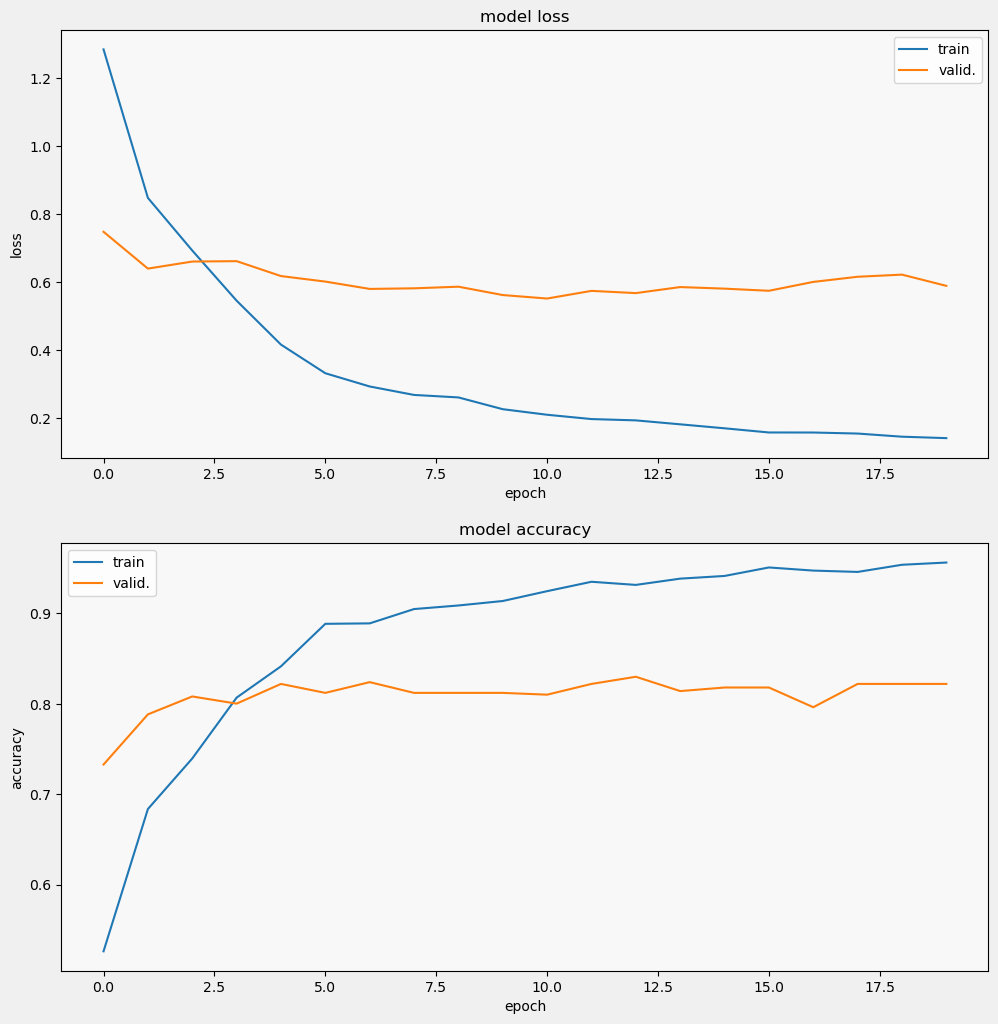

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)


In [ ]:
model.save("garbage_classifier.h5")